In [80]:
import logging
import os.path

import numpy as np
import pymc as pm
import aesara.tensor as at
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pandas as pd
import warnings
import extract_correct_csv

from deepemogp import feature_extractor
from deepemogp.signal import physio as physio
from deepemogp import datasets as datasets
from deepemogp.signal import behavior as behavior

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

scaler = StandardScaler()

valid_subject = extract_correct_csv.extract_only_valid_subject()
valid_k_list = list(range(1, 10))

k=5
i =2
num_trials_to_remove = 48

string_subject = extract_correct_csv.read_correct_subject_csv(i)
csv_ = 'data/LookAtMe_0' + string_subject + '.csv'
# csv_ = '/home/paolo/matteo/matteo/unimi/tesi_master/code/osfstorage-archive/behavior/LookAtMe_045.csv'
global_data = pd.read_csv(csv_, sep='\t')
y = np.array(list([int(d > 2) for d in global_data['rating']]))
e_labels = y[:, np.newaxis]  # rating > 2
e_labels = e_labels[num_trials_to_remove:]


TRIAL = 160

hr = pd.read_csv('data/features/hr/'+str(i)+'.csv')
hr = hr[num_trials_to_remove:]

eda = pd.read_csv('data/features/eda/' + str(i) + '.csv')
eda = eda[num_trials_to_remove:]

pupil = pd.read_csv('data/features/pupil/' + str(i) + '.csv')
pupil = pupil[num_trials_to_remove:]



In [ ]:
TRAIN_PERC =0.75
TEST_PERC = 1-TRAIN_PERC

In [ ]:
pupil_train_len = int(TRAIN_PERC*len(pupil))
pupil_test_len = len(pupil)-pupil_train_len

hr_train_len = int(TRAIN_PERC*len(hr))
hr_test_len = len(hr)-hr_train_len

eda_train_len = int(TRAIN_PERC*len(eda))
eda_test_len = len(eda)-eda_train_len

e_labels_train_len = int(TRAIN_PERC*len(e_labels))
e_labels_test_len = len(e_labels)-e_labels_train_len

In [ ]:
pupil_train = pupil[:pupil_train_len]
hr_train = hr[:hr_train_len]
eda_train = eda[:eda_train_len]
e_labels_train = e_labels[:e_labels_train_len]

In [ ]:
pupil_test = pupil[pupil_train_len:]
hr_test = hr[hr_train_len:]
eda_test = eda[eda_train_len:]
e_labels_test = e_labels[e_labels_train_len:]

In [ ]:
N_pupil = pupil_train.shape[0]
D_pupil = pupil_train.shape[1]

N_hr = hr_train.shape[0]
D_hr = hr_train.shape[1]

N_eda = eda_train.shape[0]
D_eda = eda_train.shape[1]

N_e = e_labels_train.shape[0]
D_e = e_labels_train.shape[1]

K = k

In [ ]:
print(N_pupil, D_pupil)
print(N_hr, D_hr)
print(N_eda, D_eda)
print(N_e, D_e)

In [53]:

with pm.Model() as sPPCA:
    # dati osservabili
    hr_data = pm.MutableData("hr_data", hr_train.T)
    pupil_data = pm.MutableData("pupil_data", pupil_train.T)
    eda_data = pm.MutableData("eda_data", eda_train.T)

    e_data = pm.ConstantData("e_data", e_labels_train.T)

    # matrici pesi
    Whr = pm.Normal('Whr', mu=at.zeros([D_hr, K]), sigma=2.0 * at.ones([D_hr, K]), shape=[D_hr, K])
    Wpupil = pm.Normal('Wpupil', mu=at.zeros([D_pupil, K]), sigma=2.0 * at.ones([D_pupil, K]),
                       shape=[D_pupil, K])

    Weda = pm.Normal('Weda', mu=at.zeros([D_eda, K]), sigma=2.0 * at.ones([D_eda, K]), shape=[D_eda, K])

    # weight matrix for pain expectation.
    # check mu,sigma,shape
    We = pm.Normal('W_e', mu=at.zeros([D_e, K]), sigma=2.0 * at.ones([D_e, K]), shape=[D_e, K])

    # latent space
    c = pm.Normal('c', mu=at.zeros([N_hr, K]), sigma=at.ones([N_hr, K]), shape=[N_hr, K])

    # dati dell'hrv interpretati come una gaussiana
    mu_hr = pm.Normal('mu_hr', Whr.dot(c.T), at.ones([D_hr, N_hr]))  # hyperprior 1
    sigma_hr = pm.Exponential('sigma_hr', at.ones([D_hr, N_hr]))  # hyperprior 2
    x_hr = pm.Normal('x_hr', mu=mu_hr, sigma=sigma_hr, shape=[D_hr, N_hr], observed=hr_data)

    # dati della dilatazione pupille interpretati come una gaussiana
    mu_pupil = pm.Normal('mu_pupil', Wpupil.dot(c.T), at.ones([D_pupil, N_pupil]))  # hyperprior 1
    sigma_pupil = pm.Exponential('sigma_pupil', at.ones([D_pupil, N_pupil]))  # hyperprior 2
    x_pupil = pm.Normal('x_pupil', mu=mu_pupil, sigma=sigma_pupil, shape=[D_pupil, N_pupil],
                        observed=pupil_data)

    # eda
    mu_eda = pm.Normal('mu_eda', Weda.dot(c.T), at.ones([D_eda, N_eda]))  # hyperprior 1
    sigma_eda = pm.Exponential('sigma_eda', at.ones([D_eda, N_eda]))  # hyperprior 2
    x_eda = pm.Normal('x_eda', mu=mu_eda, sigma=sigma_eda, shape=[D_eda, N_eda], observed=eda_data)

    # pain expectation. ciò che dovremmo inferire dato c
    # due strade: binary o multiclass (1-4)
    # p = probability of success?
    x_e = pm.Bernoulli('x_e', p=pm.math.sigmoid(We.dot(c.T)), shape=[D_e, N_e], observed=e_data)

    # x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    # x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)


In [54]:
gv = pm.model_to_graphviz(sPPCA)
gv.view()

'.gv.pdf'

In [55]:
with sPPCA:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])
    trace = approx.sample(500)

Finished [100%]: Average Loss = 1.1781e+06


In [56]:
import matplotlib.pyplot as plt
import arviz as az

In [ ]:
az.plot_trace(trace)

array([[<AxesSubplot: title={'center': 'Whr'}>,
        <AxesSubplot: title={'center': 'Whr'}>],
       [<AxesSubplot: title={'center': 'Wpupil'}>,
        <AxesSubplot: title={'center': 'Wpupil'}>],
       [<AxesSubplot: title={'center': 'Weda'}>,
        <AxesSubplot: title={'center': 'Weda'}>],
       [<AxesSubplot: title={'center': 'W_e'}>,
        <AxesSubplot: title={'center': 'W_e'}>],
       [<AxesSubplot: title={'center': 'c'}>,
        <AxesSubplot: title={'center': 'c'}>],
       [<AxesSubplot: title={'center': 'mu_hr'}>,
        <AxesSubplot: title={'center': 'mu_hr'}>],
       [<AxesSubplot: title={'center': 'mu_pupil'}>,
        <AxesSubplot: title={'center': 'mu_pupil'}>],
       [<AxesSubplot: title={'center': 'mu_eda'}>,
        <AxesSubplot: title={'center': 'mu_eda'}>],
       [<AxesSubplot: title={'center': 'sigma_hr'}>,
        <AxesSubplot: title={'center': 'sigma_hr'}>],
       [<AxesSubplot: title={'center': 'sigma_pupil'}>,
        <AxesSubplot: title={'center'

/home/paolo/matteo/matteo/unimi/tesi_master/code/my_env/lib/python3.8/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (22050) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'Whr\n0, 0'}>,
        <AxesSubplot: title={'center': 'Whr\n0, 1'}>,
        <AxesSubplot: title={'center': 'Whr\n0, 2'}>,
        <AxesSubplot: title={'center': 'Whr\n0, 3'}>],
       [<AxesSubplot: title={'center': 'Whr\n0, 4'}>,
        <AxesSubplot: title={'center': 'Whr\n1, 0'}>,
        <AxesSubplot: title={'center': 'Whr\n1, 1'}>,
        <AxesSubplot: title={'center': 'Whr\n1, 2'}>],
       [<AxesSubplot: title={'center': 'Whr\n1, 3'}>,
        <AxesSubplot: title={'center': 'Whr\n1, 4'}>,
        <AxesSubplot: title={'center': 'Whr\n2, 0'}>,
        <AxesSubplot: title={'center': 'Whr\n2, 1'}>],
       [<AxesSubplot: title={'center': 'Whr\n2, 2'}>,
        <AxesSubplot: title={'center': 'Whr\n2, 3'}>,
        <AxesSubplot: title={'center': 'Whr\n2, 4'}>,
        <AxesSubplot: title={'center': 'Whr\n3, 0'}>],
       [<AxesSubplot: title={'center': 'Whr\n3, 1'}>,
        <AxesSubplot: title={'center': 'Whr\n3, 2'}>,
        <AxesSubplot: ti

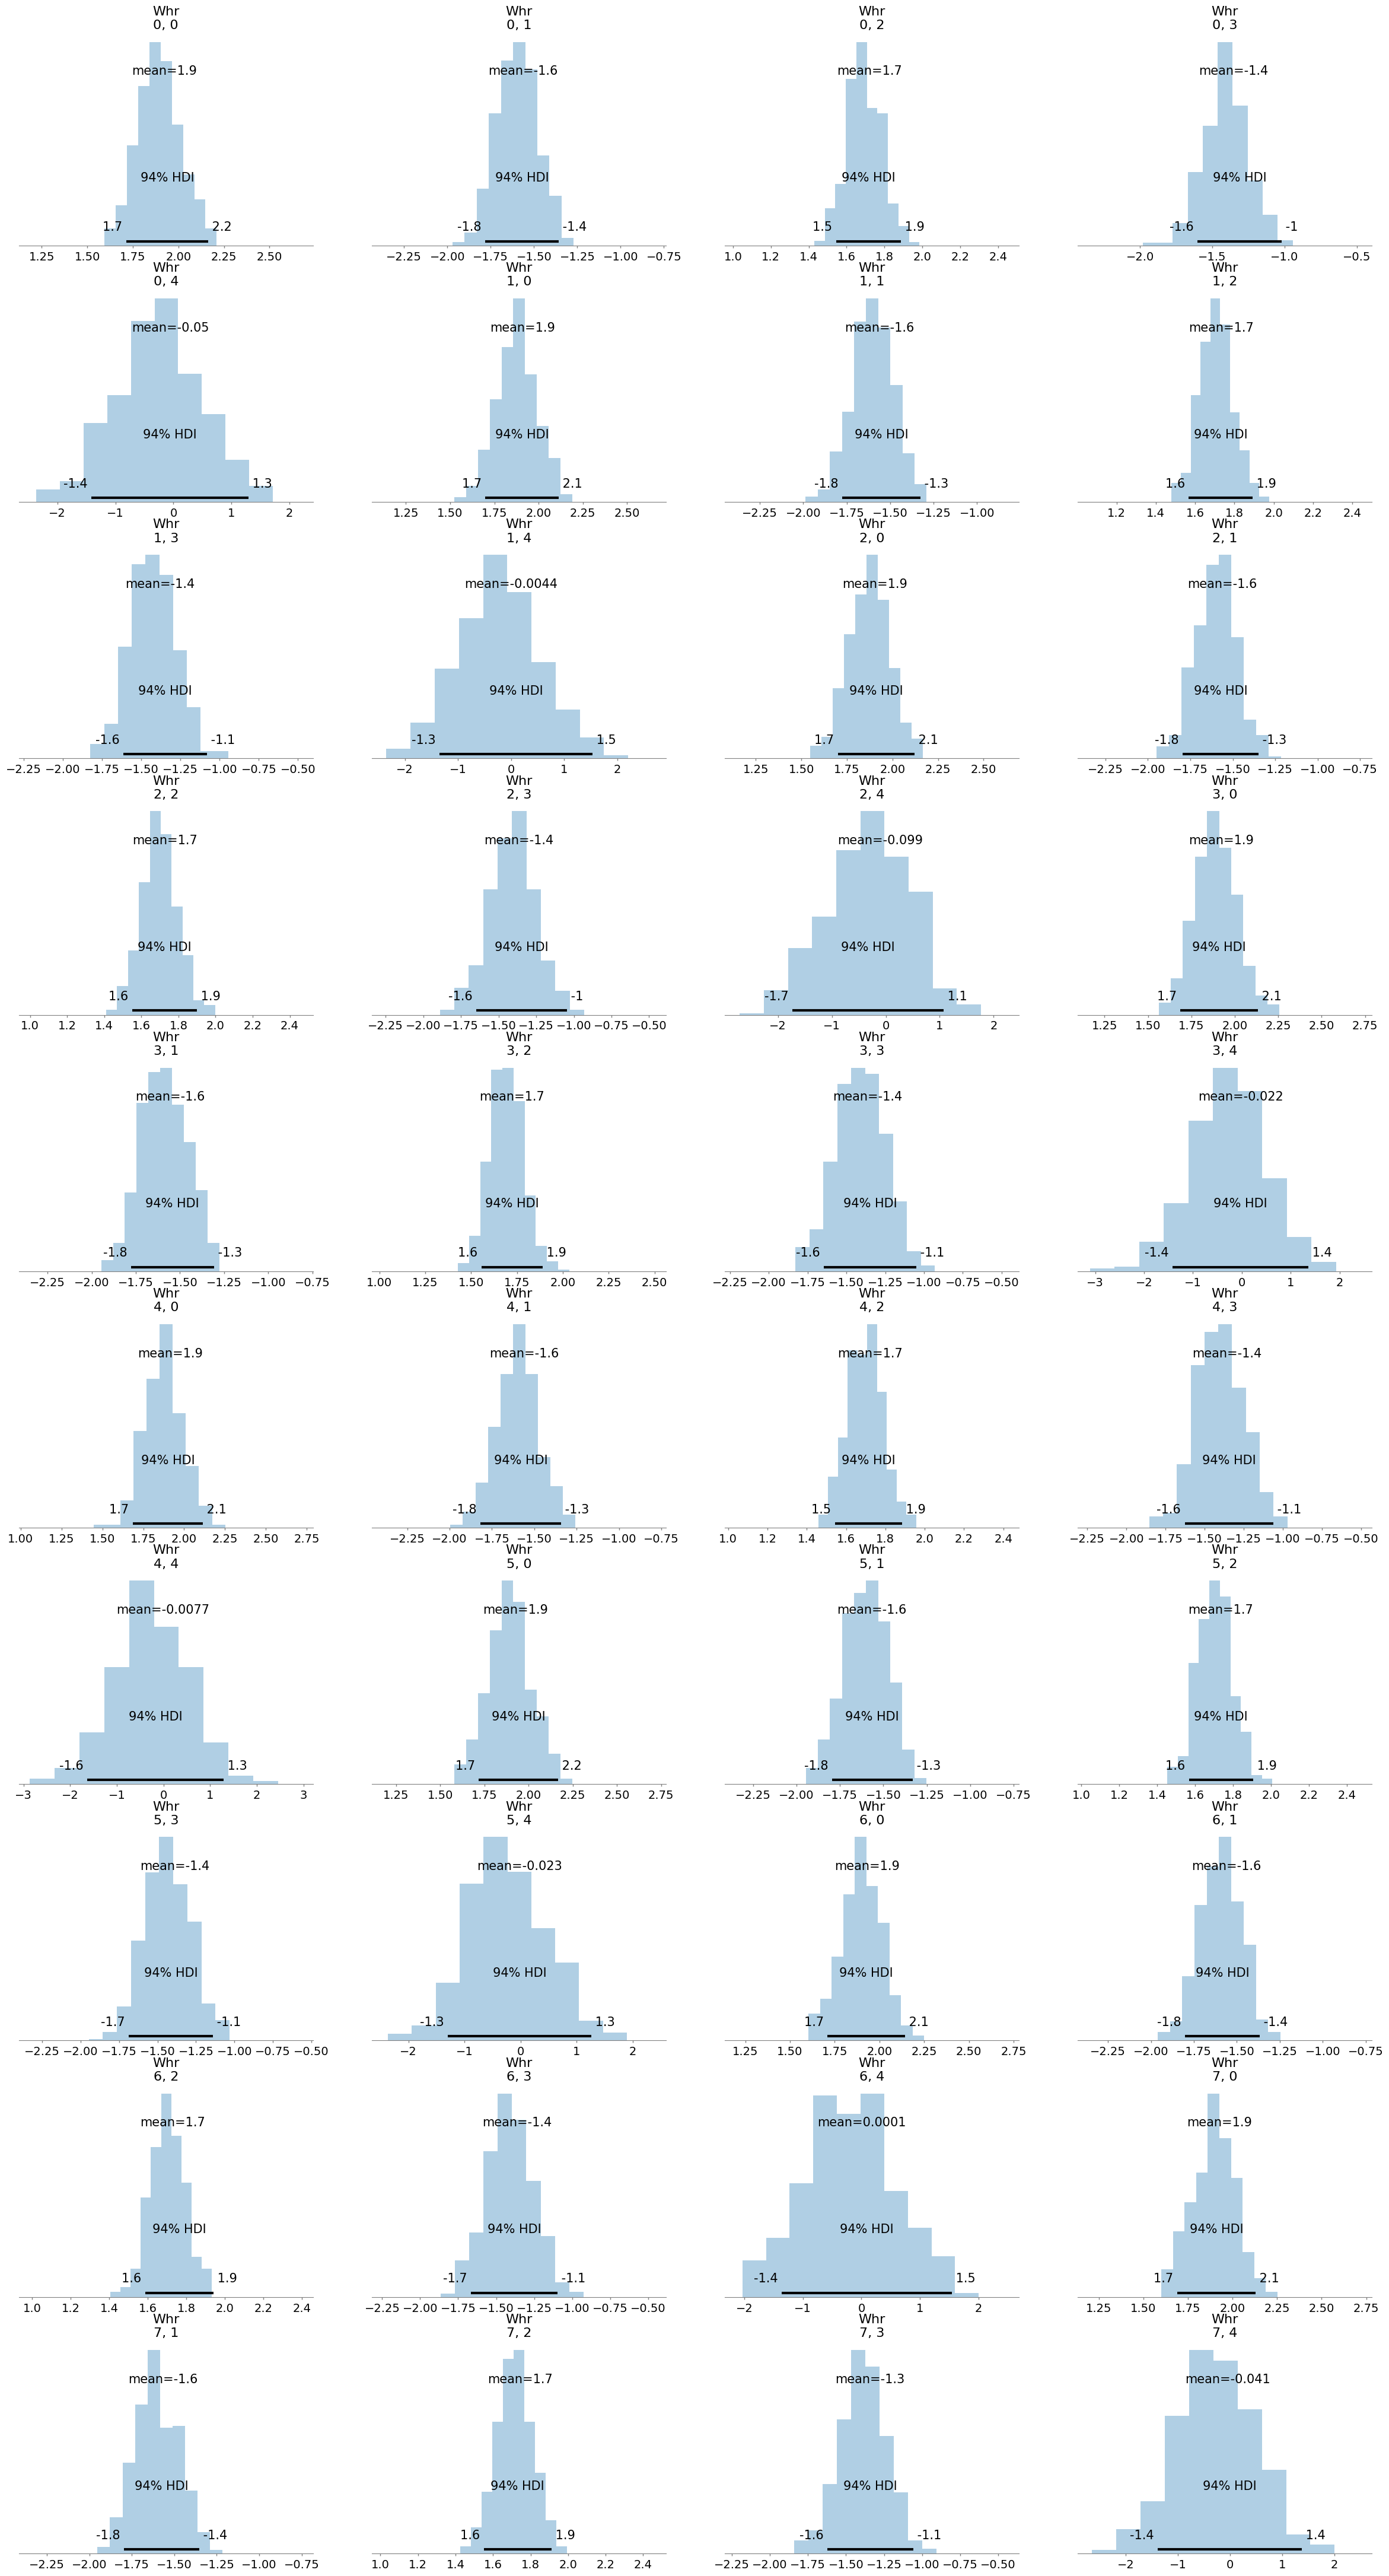

In [58]:
az.plot_posterior(trace, kind="hist")

In [70]:
# az.plot_trace(trace);
with sPPCA:
    # update values of predictors:
    pm.set_data({"pupil_data": pupil_test, "hr_data": hr_test, "eda_data": eda_test})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace,var_names=["x_e"], random_seed=123)

Sampling: [x_e]


<xarray.DataArray 'x_e' (chain: 1, draw: 500, x_e_dim_0: 1, x_e_dim_1: 84)>
array([[[[1, 1, 1, ..., 1, 0, 1]],

        [[1, 1, 1, ..., 1, 0, 0]],

        [[1, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 1, 0, 1]],

        [[1, 0, 0, ..., 0, 0, 0]],

        [[1, 0, 0, ..., 1, 1, 1]]]])
Coordinates:
  * chain      (chain) int64 0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * x_e_dim_0  (x_e_dim_0) int64 0
  * x_e_dim_1  (x_e_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 76 77 78 79 80 81 82 83

In [72]:
e_pred = posterior_predictive.posterior_predictive["x_e"]
print(e_pred)

<xarray.DataArray 'x_e' (chain: 1, draw: 500, x_e_dim_0: 1, x_e_dim_1: 84)>
array([[[[1, 1, 1, ..., 1, 0, 1]],

        [[1, 1, 1, ..., 1, 0, 0]],

        [[1, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 1, 0, 1]],

        [[1, 0, 0, ..., 0, 0, 0]],

        [[1, 0, 0, ..., 1, 1, 1]]]])
Coordinates:
  * chain      (chain) int64 0
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * x_e_dim_0  (x_e_dim_0) int64 0
  * x_e_dim_1  (x_e_dim_1) int64 0 1 2 3 4 5 6 7 8 ... 76 77 78 79 80 81 82 83


In [73]:
e_pred = posterior_predictive.posterior_predictive["x_e"]
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])

In [77]:
len(e_pred_mode)

84

In [75]:
e_labels_test

array([[1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1]])

In [76]:
train_accuracy_exp = accuracy_score(e_labels_test, e_pred_mode)
print('\n\tTrain Accuracy Pain Expectation: ' + str(train_accuracy_exp))
print(' ')

ValueError: Found input variables with inconsistent numbers of samples: [28, 84]

In [31]:
eda_pred = np.squeeze(eda_pred.mean('draw', keepdims='false')[0]).to_numpy()


	Train Accuracy Pain Expectation: 0.32142857142857145
 


NameError: name 'eda_pred' is not defined

In [ ]:
edapred_ = eda_pred.T

eda_ = eda.to_numpy()

corrlist = []
for i in range(112):
    res = np.corrcoef(eda_[i], edapred_[i])[0][1]
    corrlist.append(res)
    print('trial '+str(i)+ ' corr: '+str(res.round(3)))

In [ ]:
def ccc(x, y):
    ''' Concordance Correlation Coefficient'''
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.shape[0]
    rhoc = 2 * sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean()) ** 2)
    return rhoc

In [ ]:
ccc(edapred_[0],eda_[0])

In [ ]:
eda_[0]

In [ ]:
edapred_[0].shape

In [ ]:
x=eda_[0]
y=eda_pred[0]

In [ ]:
print(x.shape)
print(y.shape)

In [ ]:
x- x.mean()

In [ ]:
y-y.mean()

In [ ]:
(x - x.mean()) * (y - y.mean())


In [ ]:
sxy= np.sum() / x.shape[0]

In [ ]:
conc = ccc(eda_[0], eda_pred[0])

In [ ]:
pearson_list = []
concord_list = []
for i in range(112):
    pear = np.corrcoef(eda_[i], edapred_[i])[0][1]
    conc = ccc(eda_[i], eda_pred[i])
    pearson_list.append(pear)
    concord_list.append(conc)
    # print('trial ' + str(i) + ' corr: ' + str(res.round(3)))

In [ ]:
mean_pear = round(np.mean(pearson_list), 4)
mean_corc = round(np.mean(concord_list), 4)

In [ ]:
mean_subj = round(np.mean(corrlist),4)


        logging.basicConfig(level=logging.INFO, filename="logfile", filemode="a+",
                            format="%(asctime)-15s %(levelname)-8s %(message)s")
        logging.info("Mean corr coeff eda-hr using subj: " + str(subj_) + " " + str(round(mean_subj, 2)) + " script: " +
             os.path.basename(__file__) + "latent space dims: " + str(K))
